# <span style="color: blue;">ให้กรอกรหัสนิสิต และชื่อ-นามสกุลของสมาชิกในทีม</span>
# <span style="color: blue;">(ห้ามมีสมาชิกเกิน 2 คน)</span>
## รหัสนิสิต ชื่อ-นามสกุล

## Using Keras to Build and Train Neural Networks

In this exercise we will use a neural network to predict diabetes using the Pima Diabetes Dataset.  We will start by training a Random Forest to get a performance baseline.  Then we will use the Keras package to quickly build and train a neural network and compare the performance.  We will see how different network structures affect the performance, training time, and level of overfitting (or underfitting).

## Pima Diabetes Dataset

* Kaggle Dataset (https://www.kaggle.com/datasets/kumargh/pimaindiansdiabetescsv)


### Attributes: (all numeric-valued)
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)

The UCI Pima Diabetes Dataset which has 8 numerical predictors and a binary outcome.

In [1]:
#Preliminaries

from __future__ import absolute_import, division, print_function  # Python 2/3 compatibility

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns

%matplotlib inline

In [2]:
## Import Keras objects for Deep Learning

from tensorflow.keras.models  import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

In [3]:
## Load in the data set (Internet Access needed)
# Download pima-indians-diabetes.csv from https://www.kaggle.com/datasets/kumargh/pimaindiansdiabetescsv

seed_value = 11111
url = "pima-indians-diabetes.csv"
names = ["times_pregnant", "glucose_tolerance_test", "blood_pressure", 
         "skin_thickness", "insulin", "bmi", "pedigree_function", 
         "age", "has_diabetes"]
diabetes_df = pd.read_csv(url, names=names)

In [4]:
# Take a peek at the data -- if there are lots of "NaN" you may have internet connectivity issues
print(diabetes_df.shape)
diabetes_df.sample(5)

(768, 9)


,times_pregnant,glucose_tolerance_test,blood_pressure,skin_thickness,insulin,bmi,pedigree_function,age,has_diabetes
262,4,95,70,32,0,32.1,0.612,24,0
281,10,129,76,28,122,35.9,0.280,39,0
276,7,106,60,24,0,26.5,0.296,29,1
233,4,122,68,0,0,35.0,0.394,29,0
394,4,158,78,0,0,32.9,0.803,31,1


In [5]:
X = diabetes_df.iloc[:, :-1].values
y = diabetes_df["has_diabetes"].values

In [6]:
# Split the data to Train, and Test (75%, 25%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed_value, stratify=y)

In [7]:
np.mean(y), np.mean(1-y)

(0.3489583333333333, 0.6510416666666666)

Above, we see that about 35% of the patients in this dataset have diabetes, while 65% do not.  This means we can get an accuracy of 65% without any model - just declare that no one has diabetes. We will calculate the ROC-AUC score to evaluate performance of our model, and also look at the accuracy as well to see if we improved upon the 65% accuracy.
## Exercise: Get a baseline performance using Random Forest
To begin, and get a baseline for classifier performance:
1. Train a Random Forest model with 200 trees on the training data.
2. Calculate the accuracy and roc_auc_score of the predictions.

In [8]:
## Train the RF Model
rf_model = RandomForestClassifier(n_estimators=200, random_state=seed_value)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=11111)

In [9]:
# Make predictions on the test set - both "hard" predictions, and the scores (percent of trees voting yes)
y_pred_class_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)

print('accuracy is {:.3f}, roc-auc is {:.3f}'.format(
    accuracy_score(y_test, y_pred_class_rf), roc_auc_score(y_test, y_pred_prob_rf[:,1])))

accuracy is 0.771, roc-auc is 0.795


#### Let's fit our model for 100 epochs.

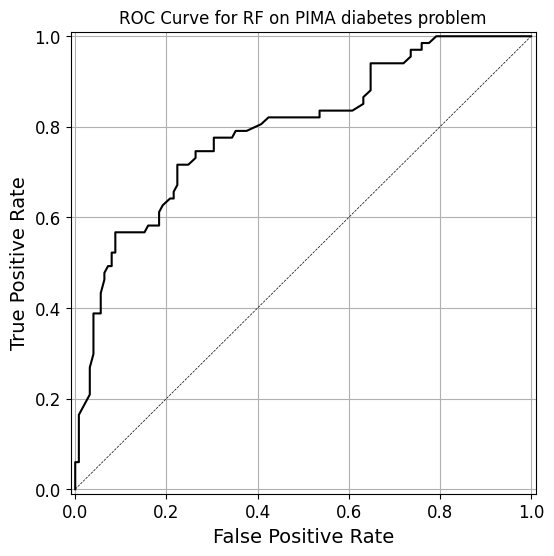

In [10]:
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {} on PIMA diabetes problem'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])
    ax.tick_params(axis='both', which='major', labelsize=12)  
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)

plot_roc(y_test, y_pred_prob_rf[:, 1], 'RF')

## Build a Single Hidden Layer Neural Network

We will use the Sequential model to quickly build a neural network.  Our first network will be a single layer network.  We have 8 variables, so we set the input shape to 8.  Let's start by having a single hidden layer with 8 nodes.

In [11]:
## First let's normalize the data
## This aids the training of neural nets by providing numerical stability
## Random Forest does not need this as it finds a split only, as opposed to performing matrix multiplications

normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

In [12]:
# Define the Model 
# Input size is 8-dimensional
# 1 hidden layer, 8 hidden nodes, sigmoid activation
# Final layer has just one node with a sigmoid activation (standard for binary classification)

import os, random, numpy as np
import tensorflow as tf 

random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)

model_1 = Sequential([
    Dense(8, input_shape=(8, ), activation="relu"),
    Dense(1, activation="sigmoid")
])

In [13]:
#  This is a nice tool to view the model you have created and count the parameters

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Fit(Train) the Model

# Compile the model with Optimizer, Loss Function and Metrics
# Roc-Auc is not available in Keras as an off the shelf metric yet, so we will skip it here.

model_1.compile(optimizer=SGD(learning_rate=0.003), loss="binary_crossentropy", metrics=["accuracy"])

run_hist_1 = model_1.fit(X_train_norm, y_train, validation_split=0.1, epochs=100, batch_size=32)
# the fit function returns the run history. 
# It is very convenient, as it contains information about the model fit, iterations etc.

Epoch 1/100
17/17 [==============================] - 2s 12ms/step - loss: 0.7665 - accuracy: 0.4710 - val_loss: 0.7636 - val_accuracy: 0.4138
Epoch 2/100
17/17 [==============================] - 0s 3ms/step - loss: 0.7601 - accuracy: 0.4768 - val_loss: 0.7545 - val_accuracy: 0.4655
Epoch 3/100
17/17 [==============================] - 0s 3ms/step - loss: 0.7533 - accuracy: 0.4923 - val_loss: 0.7460 - val_accuracy: 0.4828
Epoch 4/100
17/17 [==============================] - 0s 3ms/step - loss: 0.7472 - accuracy: 0.5039 - val_loss: 0.7384 - val_accuracy: 0.4828
Epoch 5/100
17/17 [==============================] - 0s 2ms/step - loss: 0.7417 - accuracy: 0.5097 - val_loss: 0.7320 - val_accuracy: 0.4828
Epoch 6/100
17/17 [==============================] - 0s 2ms/step - loss: 0.7368 - accuracy: 0.5251 - val_loss: 0.7259 - val_accuracy: 0.5172
Epoch 7/100
17/17 [==============================] - 0s 2ms/step - loss: 0.7320 - accuracy: 0.5367 - val_loss: 0.7194 - val_accuracy: 0.5345
Epoch 8/100


In [15]:
## Like we did for the Random Forest, we generate two kinds of predictions
#  One is a hard decision, the other is a probabilitistic score.

y_pred_prob_nn_1 = model_1.predict(X_test_norm)
y_pred_class_nn_1 = (y_pred_prob_nn_1 >= 0.5).astype('int32')

6/6 [==============================] - 0s 839us/step


In [16]:
# Let's check out the outputs to get a feel for how keras apis work.
y_pred_prob_nn_1[:10]

array([[0.5086168 ],
       [0.29213166],
       [0.40649134],
       [0.22945811],
       [0.5572396 ],
       [0.5367722 ],
       [0.4882962 ],
       [0.24659488],
       [0.28590763],
       [0.7772217 ]], dtype=float32)

In [17]:
y_pred_class_nn_1[:10]

array([[1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1]])

accuracy is 0.708, roc-auc is 0.811


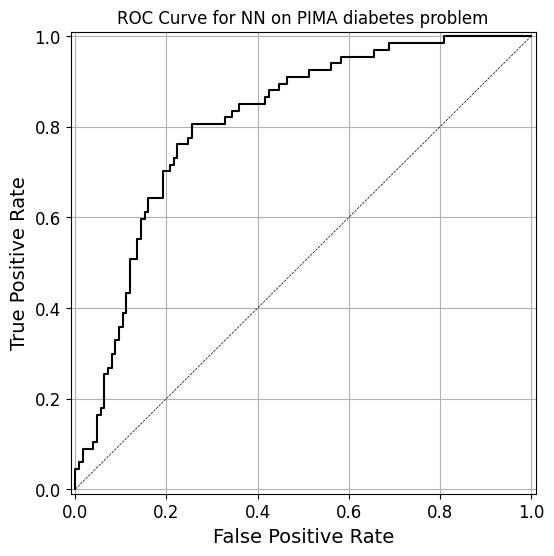

In [18]:
# Print model performance and plot the roc curve
print('accuracy is {:.3f}, roc-auc is {:.3f}'.format(
    accuracy_score(y_test, y_pred_class_nn_1), roc_auc_score(y_test, y_pred_prob_nn_1)))

plot_roc(y_test, y_pred_prob_nn_1, 'NN')

There may be some variation in exact numbers due to randomness, but you should get results in the same ballpark as the Random Forest - between 75% and 85% accuracy, between .8 and .9 for AUC.

Let's look at the `run_hist_1` object that was created, specifically its `history` attribute.

In [19]:
run_hist_1.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Let's plot the training loss and the validation loss over the different epochs and see how it looks.

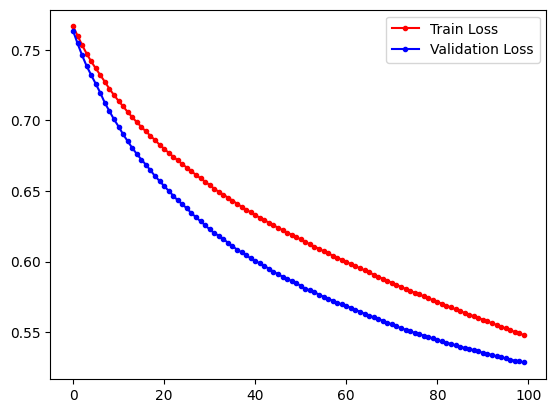

In [20]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

Looks like the losses are still going down on both the training set and the validation set.  This suggests that the model might benefit from further training.  Let's train the model a little more and see what happens. Note that it will pick up from where it left off. Train for 400 more epochs.

In [21]:
## Note that when we call "fit" again, it picks up where it left off
run_hist_1b = model_1.fit(X_train_norm, y_train, validation_split=0.1, epochs=400, batch_size=32)

Epoch 1/400
17/17 [==============================] - 0s 4ms/step - loss: 0.5466 - accuracy: 0.7432 - val_loss: 0.5276 - val_accuracy: 0.7931
Epoch 2/400
17/17 [==============================] - 0s 2ms/step - loss: 0.5455 - accuracy: 0.7452 - val_loss: 0.5269 - val_accuracy: 0.7931
Epoch 3/400
17/17 [==============================] - 0s 2ms/step - loss: 0.5444 - accuracy: 0.7452 - val_loss: 0.5260 - val_accuracy: 0.7931
Epoch 4/400
17/17 [==============================] - 0s 2ms/step - loss: 0.5432 - accuracy: 0.7452 - val_loss: 0.5252 - val_accuracy: 0.7931
Epoch 5/400
17/17 [==============================] - 0s 2ms/step - loss: 0.5422 - accuracy: 0.7471 - val_loss: 0.5248 - val_accuracy: 0.7931
Epoch 6/400
17/17 [==============================] - 0s 2ms/step - loss: 0.5410 - accuracy: 0.7471 - val_loss: 0.5245 - val_accuracy: 0.7931
Epoch 7/400
17/17 [==============================] - 0s 2ms/step - loss: 0.5399 - accuracy: 0.7490 - val_loss: 0.5239 - val_accuracy: 0.7931
Epoch 8/400
1

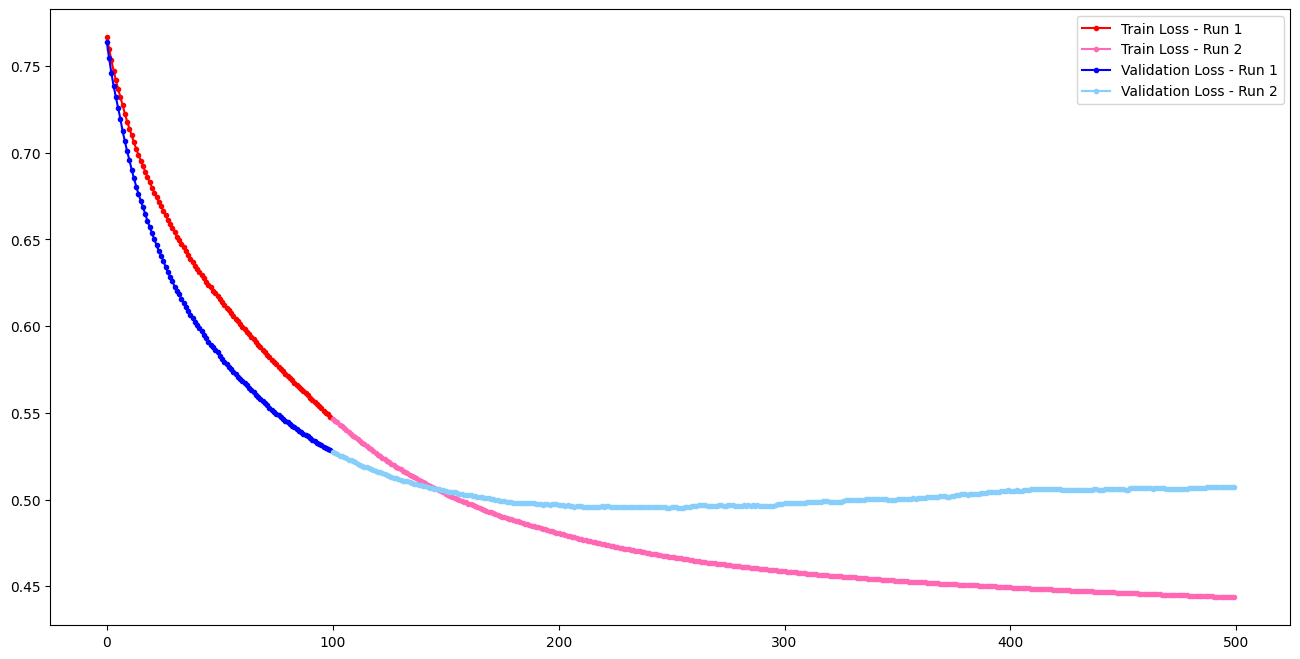

In [22]:
n = len(run_hist_1.history["loss"])
m = len(run_hist_1b.history['loss'])
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(range(n), run_hist_1.history["loss"],'r', marker='.', label="Train Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["loss"], 'hotpink', marker='.', label="Train Loss - Run 2")

ax.plot(range(n), run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["val_loss"], 'LightSkyBlue', marker='.',  label="Validation Loss - Run 2")

ax.legend()

Note that this graph begins where the other left off.  While the training loss is still going down, it looks like the validation loss has stabilized (or even gotten worse!).  This suggests that our network will not benefit from further training.  What is the appropriate number of epochs?

## <span style="color: green;">จงแสดงวิธีคำนวณจำนวนพารามิเตอร์ของโมเดลนี้ซึ่งมี 81 ตัว โดยให้แสดงที่มาของจำนวนพารามิเตอร์ในแต่ละเลเยอร์และจำนวนรวมทั้งหมด</span>
![](https://drive.google.com/thumbnail?id=1bv9DT2b5H3dFdEe0AJT6qXVHG9h88Esl&sz=w640)

<span style="color: blue;">
โมเดลนี้ประกอบด้วย 3 Layer

Input Layer: 8 Nodes

Hidden Layer: 8 Nodes

Output Layer: 1 Node

Layer ที่มีพารามิเตอร์คือ Hidden Layer / Output Layer

จำนวนพารามิเตอร์ใน Hidden Layer = (จำนวน Node Layer นี้) * (จำนวน Node Layer ก่อนหน้า + 1(bias)) = 8 * (8+1) = 72 Params

จำนวนพารามิเตอร์ใน Output Layer = (จำนวน Node Layer นี้) * (จำนวน Node Layer ก่อนหน้า + 1(bias)) = 1 * (8+1) = 9 Params

รวมเป็น 72+9 = 81 Params
</span>

## <span style="color: green;">เพิ่ม Code Cell เพื่อ</span>
* <span style="font-size:20px;">สร้างโมเดลที่มีเลเยอร์ hidden 2 ชั้น และแต่ละชั้นมี 6 โหนด</span>
* <span style="font-size:20px;">ปรับโค้ดให้สามารถรับอินพุตที่มีจำนวน feature ตามข้อมูลเทรนที่จะถูกส่งเข้ามา (ปราศจากการใช้ค่าคงที่ 8 ที่ถูกระบุอยู่ในโค้ด ณ ตอนนี้)</span>
* <span style="font-size:20px;">สำหรับเลเยอร์ hidden ให้ใช้ activation function เป็น "relu" และเลเยอร์ output เป็น "sigmoid"</span>
* <span style="font-size:20px;">ใช้ learning rate เท่ากับ 0.003 และเทรนด้วยจำนวน 250 epochs ส่วนสำหรับ Hyperparameter ที่เหลือให้ใช้ค่าคงเดิม</span>
* <span style="font-size:20px;">วาดกราฟของค่า loss และ accuracy ด้วยทั้งชุดข้อมูล train และ test (ดังตัวอย่างในรูปนี้)</span>
![Loss and Accuracy Graph](https://drive.google.com/thumbnail?id=1GuN0KQf64rGMa4oCY2upnbOTMzWaXmbT&sz=h360)
* <span style="font-size:20px;">วาดกราฟ ROC ของทั้งชุดข้อมูล train และ test พร้อมแสดงค่า AUC ของโมเดล</span>


In [ ]:
model_2 = Sequential([
    Dense(6, input_shape=X_train_norm.shape[1:], activation="relu"),
    Dense(6, activation="relu"),
    Dense(1, activation="sigmoid")
])

model_2.summary()
model_2.compile(optimizer=SGD(learning_rate=0.003), loss="binary_crossentropy", metrics=["accuracy"])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 6)                 54        
                                                                 
 dense_9 (Dense)             (None, 6)                 42        
                                                                 
 dense_10 (Dense)            (None, 1)                 7         
                                                                 
Total params: 103
Trainable params: 103
Non-trainable params: 0
_________________________________________________________________


In [33]:
from tensorflow.keras.callbacks import Callback

class TestMetric(Callback):
    def __init__(self, X_test, y_test):
        self.X_test = X_test
        self.y_test = y_test
        self.losses = []
        self.accuracies = []

    def on_epoch_end(self, epoch, logs=None):
        loss, accuracy = self.model.evaluate(self.X_test, self.y_test, verbose=0)
        self.losses.append(loss)
        self.accuracies.append(accuracy)

In [34]:
callback = TestMetric(X_test_norm, y_test)

run_hist_2 = model_2.fit(X_train_norm, y_train, validation_split=0.1, epochs=250, batch_size=32,
                         callbacks=[callback])

Epoch 1/250
17/17 [==============================] - 1s 12ms/step - loss: 0.6889 - accuracy: 0.5637 - val_loss: 0.6677 - val_accuracy: 0.7241
Epoch 2/250
17/17 [==============================] - 0s 5ms/step - loss: 0.6873 - accuracy: 0.5695 - val_loss: 0.6654 - val_accuracy: 0.7241
Epoch 3/250
17/17 [==============================] - 0s 12ms/step - loss: 0.6858 - accuracy: 0.5772 - val_loss: 0.6629 - val_accuracy: 0.7241
Epoch 4/250
17/17 [==============================] - 0s 5ms/step - loss: 0.6842 - accuracy: 0.5888 - val_loss: 0.6605 - val_accuracy: 0.7069
Epoch 5/250
17/17 [==============================] - 0s 5ms/step - loss: 0.6827 - accuracy: 0.5888 - val_loss: 0.6585 - val_accuracy: 0.7069
Epoch 6/250
17/17 [==============================] - 0s 5ms/step - loss: 0.6813 - accuracy: 0.5965 - val_loss: 0.6567 - val_accuracy: 0.7069
Epoch 7/250
17/17 [==============================] - 0s 5ms/step - loss: 0.6800 - accuracy: 0.6023 - val_loss: 0.6546 - val_accuracy: 0.6897
Epoch 8/250

In [35]:
y_pred_prob_nn_2 = model_2.predict(X_test_norm)
y_pred_class_nn_2 = (y_pred_prob_nn_2 >= 0.5).astype('int32')

6/6 [==============================] - 0s 1ms/step


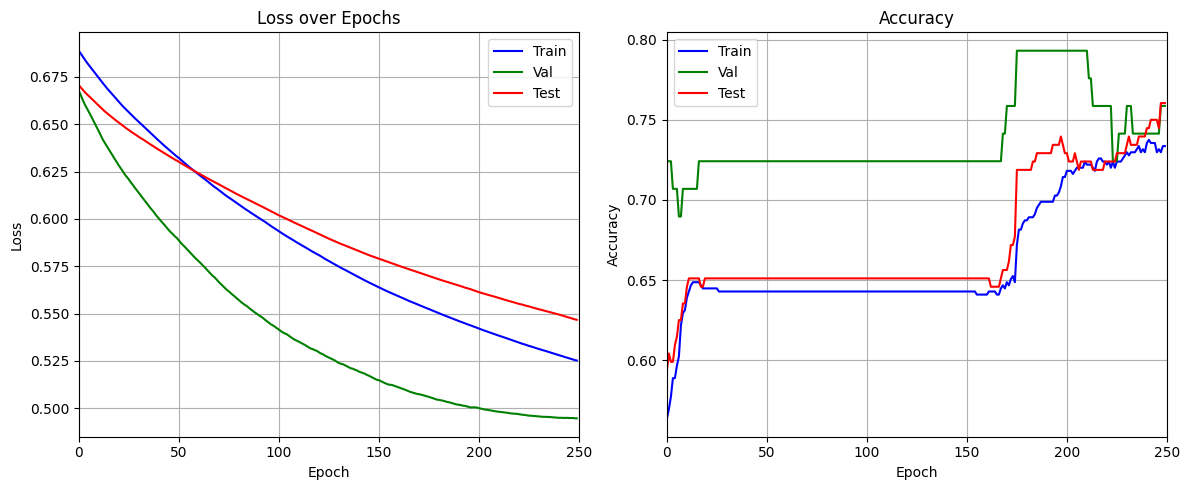

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# --- Plot Loss ---
ax1.plot(run_hist_2.history["loss"], 'b', label="Train")
ax1.plot(run_hist_2.history["val_loss"], 'g', label="Val")
ax1.plot(callback.losses, 'r', label="Test")

ax1.set_title("Loss over Epochs")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.grid(True)
ax1.set_xlim(0, len(run_hist_2.history["loss"]))
ax1.legend()

# --- Plot Accuracy ---
ax2.plot(run_hist_2.history["accuracy"], 'b', label="Train")
ax2.plot(run_hist_2.history["val_accuracy"], 'g', label="Val")
ax2.plot(callback.accuracies, 'r', label="Test")
ax2.set_title("Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.grid(True)
ax2.set_xlim(0, len(run_hist_2.history["accuracy"]))
ax2.legend()

plt.tight_layout()
plt.show()

In [113]:
y_pred_train_prob_nn_2 = model_2.predict(X_train_norm)
y_pred_train_class_nn_2 = (y_pred_train_prob_nn_2 >= 0.5).astype('int32')

18/18 [==============================] - 0s 2ms/step


Train set:
accuracy is 0.736
roc-auc is 0.811


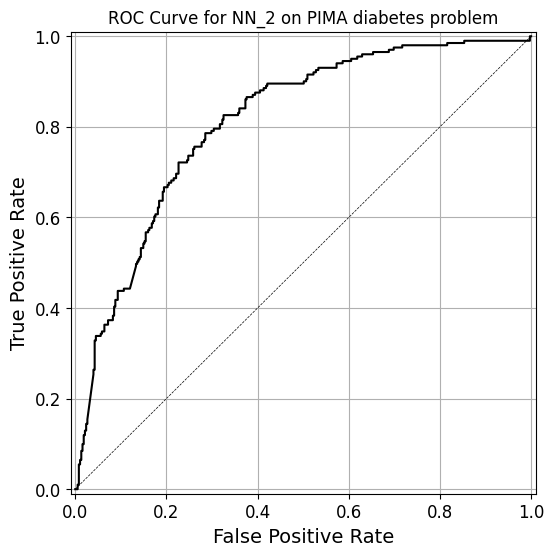

In [116]:
print('Train set:\naccuracy is {:.3f}\nroc-auc is {:.3f}'.format(
    accuracy_score(y_train, y_pred_train_class_nn_2), roc_auc_score(y_train, y_pred_train_prob_nn_2)))

plot_roc(y_train, y_pred_train_prob_nn_2, 'NN_2')

Test set: 
accuracy is 0.760
roc-auc is 0.781


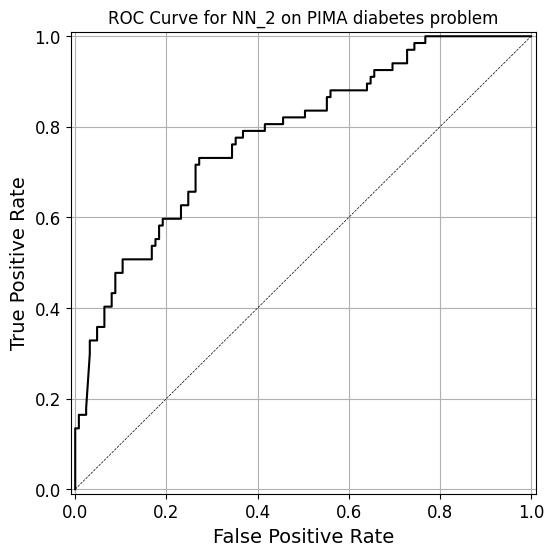

In [107]:
print('Test set: \naccuracy is {:.3f}\nroc-auc is {:.3f}'.format(
    accuracy_score(y_test, y_pred_class_nn_2), roc_auc_score(y_test, y_pred_prob_nn_2)))

plot_roc(y_test, y_pred_prob_nn_2, 'NN_2')

## <span style="color: green;">สร้างอีกโมเดลโดยปรับโครงสร้างที่เหมาะสมขึ้น รวมถึงการปรับค่า Hyperparameter ต่าง ๆ เพื่อให้โมเดลได้ประสิทธิภาพที่ดีขึ้นโดยพิจารณาจากค่า AUC</span>  
* <span style="font-size:20px;">ให้วาดกราฟของค่า loss และ accuracy ของโมเดลใหม่นี้ด้วย</span>
* <span style="font-size:20px;">วาดกราฟ ROC ของทั้งชุดข้อมูล train และ test พร้อมแสดงค่า AUC ของโมเดล</span>
* <span style="font-size:20px">อธิบายให้เห็นว่าผลลัพธ์ที่ได้จากโมเดลใหม่นั้นดีขึ้นจากโมเดลเดิม</span>

In [101]:
model_3 = Sequential([
    Dense(16, input_shape=X_train_norm.shape[1:], activation="relu"),
    Dense(16, activation="relu"),
    Dense(1, activation="sigmoid")
])

model_3.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_50 (Dense)            (None, 16)                144       
                                                                 
 dense_51 (Dense)            (None, 16)                272       
                                                                 
 dense_52 (Dense)            (None, 1)                 17        
                                                                 
Total params: 433
Trainable params: 433
Non-trainable params: 0
_________________________________________________________________


In [102]:
epochs_3 = 500
lr_3 = 0.0025
batch_size_3 = 64

model_3.compile(optimizer=SGD(learning_rate=lr_3), loss="binary_crossentropy", metrics=["accuracy"])
callback_3 = TestMetric(X_test_norm, y_test)
run_hist_3 = model_3.fit(X_train_norm, y_train, validation_split=0.2, epochs=epochs_3, batch_size=batch_size_3,
                         callbacks=[callback_3])

Epoch 1/500
8/8 [==============================] - 1s 25ms/step - loss: 0.6545 - accuracy: 0.6130 - val_loss: 0.6525 - val_accuracy: 0.6034
Epoch 2/500
8/8 [==============================] - 0s 10ms/step - loss: 0.6522 - accuracy: 0.6152 - val_loss: 0.6504 - val_accuracy: 0.5948
Epoch 3/500
8/8 [==============================] - 0s 10ms/step - loss: 0.6500 - accuracy: 0.6217 - val_loss: 0.6484 - val_accuracy: 0.5948
Epoch 4/500
8/8 [==============================] - 0s 10ms/step - loss: 0.6479 - accuracy: 0.6239 - val_loss: 0.6464 - val_accuracy: 0.5948
Epoch 5/500
8/8 [==============================] - 0s 10ms/step - loss: 0.6458 - accuracy: 0.6261 - val_loss: 0.6448 - val_accuracy: 0.6034
Epoch 6/500
8/8 [==============================] - 0s 10ms/step - loss: 0.6439 - accuracy: 0.6326 - val_loss: 0.6430 - val_accuracy: 0.6034
Epoch 7/500
8/8 [==============================] - 0s 11ms/step - loss: 0.6419 - accuracy: 0.6348 - val_loss: 0.6411 - val_accuracy: 0.6034
Epoch 8/500
8/8 [===

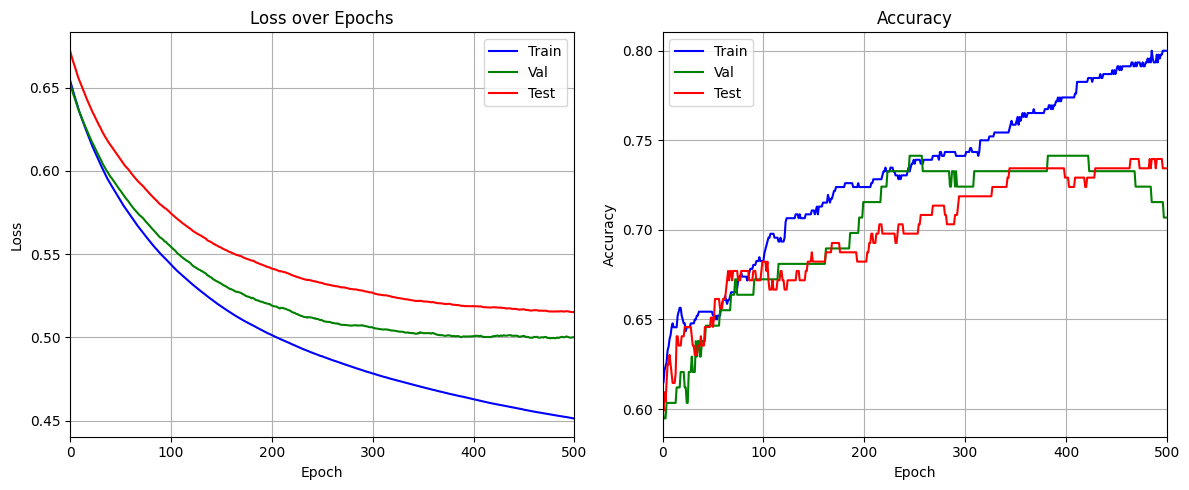

In [103]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# --- Plot Loss ---
ax1.plot(run_hist_3.history["loss"], 'b', label="Train")
ax1.plot(run_hist_3.history["val_loss"], 'g', label="Val")
ax1.plot(callback_3.losses, 'r', label="Test")

ax1.set_title("Loss over Epochs")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.grid(True)
ax1.set_xlim(0, len(run_hist_3.history["loss"]))
ax1.legend()

# --- Plot Accuracy ---
ax2.plot(run_hist_3.history["accuracy"], 'b', label="Train")
ax2.plot(run_hist_3.history["val_accuracy"], 'g', label="Val")
ax2.plot(callback_3.accuracies, 'r', label="Test")
ax2.set_title("Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.grid(True)
ax2.set_xlim(0, len(run_hist_3.history["accuracy"]))
ax2.legend()

plt.tight_layout()
plt.show()

In [119]:
y_pred_train_prob_nn_3 = model_3.predict(X_train_norm)
y_pred_train_class_nn_3 = (y_pred_train_prob_nn_3 >= 0.5).astype('int32')

y_pred_prob_nn_3 = model_3.predict(X_test_norm)
y_pred_class_nn_3 = (y_pred_prob_nn_3 >= 0.5).astype('int32')

6/6 [==============================] - 0s 798us/step


Train set: 
accuracy is 0.781
roc-auc is 0.847


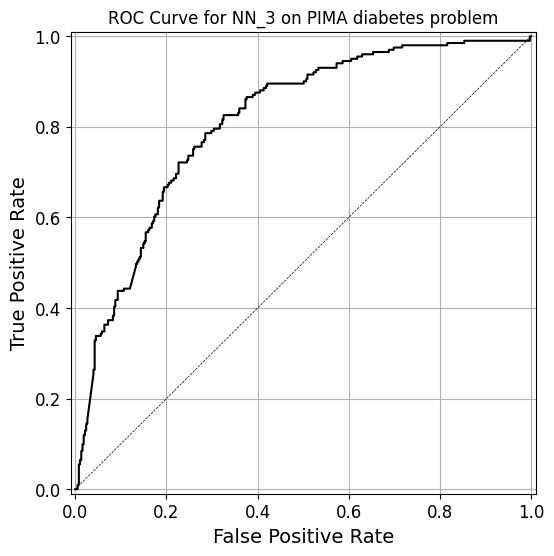

In [122]:
print('Train set: \naccuracy is {:.3f}\nroc-auc is {:.3f}'.format(
    accuracy_score(y_train, y_pred_train_class_nn_3), roc_auc_score(y_train, y_pred_train_prob_nn_3)))

plot_roc(y_train, y_pred_train_prob_nn_2, 'NN_3')

Test set: 
accuracy is 0.734
roc-auc is 0.793


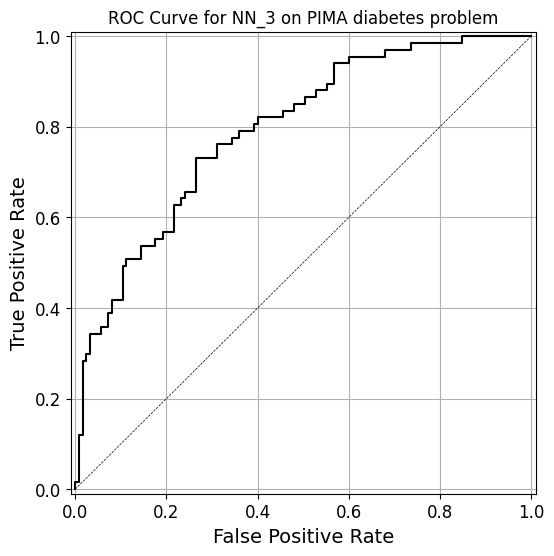

In [123]:
print('Test set: \naccuracy is {:.3f}\nroc-auc is {:.3f}'.format(
    accuracy_score(y_test, y_pred_class_nn_3), roc_auc_score(y_test, y_pred_prob_nn_3)))

plot_roc(y_test, y_pred_prob_nn_3, 'NN_3')

- auc ของโมเดลใหม่เพิ่มขึ้นจาก 0.781 เป็น 0.793 
- เนื่องจาก auc เพิ่มขึ้น หมายความว่าโมเดลใหม่มีแนวโน้มที่จะมีความสามารถในการแยกคนเป็นและไม่เป็นเบาหวานออกจากกันได้ดีกว่าโมเดลเดิม